# Observatorium


Svrha je ove *Python* bilježnice malo pregledati (opservirati) skup podataka na osnovu kojeg treba izgraditi model kao rješenje zadatka za natjecanje *Mozgalo* 2019. godine.


## Sadržaj


1.  [Učitavanje podataka](#ucitavanje-podataka)
2.  [Jednostavni pregled podataka](#jednostavni-pregled-podataka)
    1.  [Inspekcija sumnjivih dijelova](#inspekcija-sumnjivih-dijelova)
3.  [Vremenski nizovi](#vremenski-nizovi)


Pripremimo prvo okruženje


In [1]:
##  PRIPREMA PYTHON OKRUZENJA

# IPython
from IPython import *
from IPython.display import *

# Standardna Python biblioteka
import copy
import math
import os
import six
import sys
import time

# SciPy paketi
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
from mpl_toolkits.mplot3d.axes3d import Axes3D # 3-dimenzionalna grafika

# Postavi prikaz grafova unutar biljeznice.
%matplotlib inline

# Postavi stil grafova na `ggplot'.
plt.style.use('ggplot')

# Inicijaliziraj ispis simbolickog racuna.
sym.init_printing()


## Učitavanje podataka <a name="ucitavanje-podataka"></a>


Podatke ćemo iz datoteke *training_dataset_enc.csv* učitati kao `pandas.DataFrame` pozivom funkcije `pandas.read_pickle` odnosno `pandas.read_csv`. Pokretanjem sljedećih programskih linija može se primijetiti da učitavanje podataka iz *CSV* datoteke traje jako dugo zato što redaka u tablici ima više od $ 5 $ milijuna, stoga ćemo prvo pokušati otvoriti *pickle*, a, ako datoteka koju tražimo ne postoji, tek ćemo onda otvarati *CSV* i odmah ćemo učitanu tablicu spremiti kao *pickle* datoteku za kasnije brže učitavanje. Izmjerit ćemo i vrijeme potrebno za učitavanje podataka jer se iz izmjerenih vremena jasno vidi vremenska optimizacija učitavanja podataka.


In [2]:
##  UCITAVANJE SKUPA PODATAKA
##
##  S obzirom na to da je skup podataka vrlo velik (5 193 124 redaka), mjerit
##  cemo i vrijeme potrebno za njegovo ucitavanje.  Podatci bi se, medutim, iz
##  CSV datoteke puno brze ucitali da se datumi ne parsiraju, nego da ostanu
##  stringovi, ali vjerojatno ce nam datumi ionako biti potrebni u datumskom
##  obliku pa ih je bolje odmah takve i ucitati.  Stoga, jednom kada se CSV
##  ucita, sprema se pickle cijelog skupa podataka tako da svaki sljedeci put
##  ucitavanje bude puno brze (ako datoteka s pickle-om postoji, automatski se
##  skup podataka cita iz nje; CSV se cita tek ako datoteka s pickle-om ne
##  postoji).

# Pocni mjeriti vrijeme.
t0 = time.time()


# Ucitaj skup podataka.  Prvo se pokusava ucitati pickle iz datoteke
# `training_dataset_enc.pkl', a, ako ta datoteka ne postoji, onda se ucitava
# tablica u CSV obliku iz `training_dataset_enc.csv' i odmah se sprema pickle u
# datoteku `training_dataset_enc.pkl' za brze ucitavanje ubuduce.
df = None
try:
    df = pd.read_pickle('training_dataset_enc.pkl')
except FileNotFoundError:
    df = pd.read_csv(
        'training_dataset_enc.csv',
        index_col = 0,
        parse_dates = [
            'DATUM_IZVJESTAVANJA',
            'DATUM_OTVARANJA',
            'PLANIRANI_DATUM_ZATVARANJA',
            'DATUM_ZATVARANJA'
        ],
        infer_datetime_format = True,
        true_values = ['Y'],
        false_values = ['N']
    )
    df.drop(columns = 'Unnamed: 0.1', inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.KLIJENT_ID = df.KLIJENT_ID.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.KLIJENT_ID[pd.notnull(df.KLIJENT_ID)].unique()
            ),
            ordered = False
        )
    )
    df.OZNAKA_PARTIJE = df.OZNAKA_PARTIJE.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.OZNAKA_PARTIJE[pd.notnull(df.OZNAKA_PARTIJE)].unique()
            ),
            ordered = False
        )
    )
    df.VALUTA = df.VALUTA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(df.VALUTA[pd.notnull(df.VALUTA)].unique()),
            ordered = False
        )
    )
    df.VRSTA_KLIJENTA = df.VRSTA_KLIJENTA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.VRSTA_KLIJENTA[pd.notnull(df.VRSTA_KLIJENTA)].unique()
            ),
            ordered = False
        )
    )
    df.PROIZVOD = df.PROIZVOD.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(df.PROIZVOD[pd.notnull(df.PROIZVOD)].unique()),
            ordered = False
        )
    )
    df.VRSTA_PROIZVODA = df.VRSTA_PROIZVODA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.VRSTA_PROIZVODA[pd.notnull(df.VRSTA_PROIZVODA)].unique()
            ),
            ordered = False
        )
    )
    df.TIP_KAMATE = df.TIP_KAMATE.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.TIP_KAMATE[pd.notnull(df.TIP_KAMATE)].unique()
            ),
            ordered = False
        )
    )
    df.to_pickle('training_dataset_enc.pkl')

# Zavrsi mjerenje vremena.
t1 = time.time()

# Izracunaj vremenski period od t0 do t1 u sekundama.
d = float(t1 - t0)

# Ispisi vrijeme.
print(
    'Trajanje ucitavanja: {h:d}h {m:02d}m {s:06.3f}s ({S:.3f}s)'.format(
        h = int(math.floor(d / 3600)),
        m = int(math.floor((d - 3600 * int(math.floor(d / 3600))) / 60)),
        s = d - 60 * int(math.floor(d / 60)),
        S = d
    )
)

# Oslobodi memoriju.
del d
del t0
del t1


Trajanje ucitavanja: 0h 00m 00.368s (0.368s)


## Jednostavni pregled podataka <a name="jednostavni-pregled-podataka"></a>


Sada kada su podatci učitani, promotrimo malo kakvi su. Pregledat ćemo u kakvom su formatu podatci spremljeni, kako izgledaju neki od prvih i zadnjih redaka u tablici, a zatim ćemo nad svim stupcima izvršiti minimalnu deskriptivnu statistiku.


In [3]:
# Opis `feature'-a
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5193124 entries, 0 to 5193123
Data columns (total 17 columns):
DATUM_IZVJESTAVANJA               datetime64[ns]
KLIJENT_ID                        category
OZNAKA_PARTIJE                    category
DATUM_OTVARANJA                   datetime64[ns]
PLANIRANI_DATUM_ZATVARANJA        datetime64[ns]
DATUM_ZATVARANJA                  datetime64[ns]
UGOVORENI_IZNOS                   float64
STANJE_NA_KRAJU_PRETH_KVARTALA    float64
STANJE_NA_KRAJU_KVARTALA          float64
VALUTA                            category
VRSTA_KLIJENTA                    category
PROIZVOD                          category
VRSTA_PROIZVODA                   category
VISINA_KAMATE                     float64
TIP_KAMATE                        category
STAROST                           int64
PRIJEVREMENI_RASKID               bool
dtypes: bool(1), category(7), datetime64[ns](4), float64(4), int64(1)
memory usage: 432.3 MB


In [4]:
# Prvih nekoliko redaka
df.head()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
0,2013-12-31,412140,7146814,2012-08-27,2018-04-30,NaT,629155.97,639373.81,641562.01,2,1420,TM0109,L,1.50,A,22,False
1,2013-12-31,772139,5521579,2010-06-11,2017-06-30,NaT,46000.00,28481.94,26887.19,1,1410,FL0801,A,9.70,B,38,False
2,2013-12-31,481985,7443823,2013-01-23,2018-02-28,NaT,44679.50,44908.40,45062.09,2,1550,FD0100,L,3.10,A,37,False
3,2013-12-31,139014,6511639,2011-09-16,2016-09-30,NaT,29959.15,19691.64,18285.89,2,1410,FL0801,A,7.95,B,49,False
4,2013-12-31,952566,6143123,2011-05-23,2014-05-31,NaT,100000.00,24797.93,15685.33,1,1410,FL0801,A,9.70,B,35,False


In [5]:
# Zadnjih nekoliko redaka
df.tail()


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
5193119,2011-03-31,91448,5952541,2011-03-22,NaT,NaT,228977.87,NaN,228867.02,2,1410,TM0109,L,3.90,A,46,False
5193120,2011-03-31,642422,5615789,2010-08-11,2012-08-31,NaT,10420.82,8945.30,7638.62,2,1410,FL1600,A,4.00,C,62,False
5193121,2011-03-31,585010,1267220,2003-10-20,2028-10-31,NaT,486353.44,419939.30,416042.95,2,1410,FL1301,A,8.50,C,41,False
5193122,2012-03-31,330608,1413623,2006-10-27,2013-10-31,NaT,102421.36,40550.36,37387.95,4,1410,FL1201,A,4.95,C,40,False
5193123,2012-03-31,78952,6735617,2012-02-09,NaT,NaT,3000.00,NaN,3000.00,1,1410,TM0109,L,3.70,A,69,False


Definirat cemo i neke funkcije koje ce nam olaksati jednostavnu analizu stupaca.


In [6]:
##  DEFINICIJE NEKIH FUNKCIJA ZA ANALIZU PODATAKA

def analiziraj_num_stupac (col):
    """
    Saznaj neke podatke o stupcu s numerickim vrijednostima.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi biti numerickog tipa.  Ako ti
    zahtjevi nisu ispunjeni, ponasanje funkcije moze biti neocekivano.

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'min'   --  najmanja vrijednost u stupcu,
        --  'max'   --  najveca vrijednost u stupcu,
        --  'range' --  raspon vrijednosti u stupcu (max - min),
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'uniques'   --  broj jedinstvenih definiranih vrijednosti u stupcu.

    Ostatak deskriptivne statistike ne racuna se jer se takvi podatci (pa cak i
    neki od ovdje izracunatih) mogu dehvatiti pozivom metode
    pandas.DataFrame.describe.

    """

    nonvalids = pd.isnull(col)
    extrmin = col.min()
    extrmax = col.max()

    return {
        'min' : extrmin,
        'max' : extrmax,
        'range' : extrmax - extrmin,
        'nulls' : int(nonvalids.sum()),
        'uniques' : int(col[np.logical_not(nonvalids)].unique().size)
    }

def analiziraj_bool_stupac (col):
    """
    Saznaj neke podatke o stupcu s vrijednostima istina/laz.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi biti vrijednosti istina/laz.  Ako
    ti zahtjevi nisu ispunjeni, ponasanje funkcije moze biti neocekivano.  Ipak,
    ponekad je korisno i za, na primjer, numericke stupce saznati koliko imaju
    vrijednosti jednakih 0, a koliko razlicitih 0: poziv ove funkcije nad
    numerickim stupcem vraca upravo takve podatke.  U biti, sve se definirane
    vrijednosti u stupcu prvo pokusaju interpretirati kao vrijednosti istina/laz
    i onda se takav stupac analizira.  Dakle, ponasanje i povratna vrijednost
    funkcije ovise o nacinu konverzije podataka.

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'trues' --  broj istinitih vrijednosti u stupcu,
        --  'falses'    --  broj laznih vrijednosti u stupcu.

    """

    nonvalids = pd.isnull(col)
    bools = col[np.logical_not(nonvalids)].astype(bool)
    trues = int(bools.sum())
    falses = int(bools.size - trues)

    return {
        'nulls' : int(nonvalids.sum()),
        'trues' : trues,
        'falses' : falses
    }

def analiziraj_str_stupac (col):
    """
    Saznaj neke podatke o stupcu s kategorickim vrijednostima.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi sadrzavati kategoricke
    vrijednosti (najcesce u obliku stringova, ali moze biti i bilo kojeg drugog
    tipa).

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'uniques'   --  broj jedinstvenih definiranih vrijednosti u stupcu.

    """

    nonvalids = pd.isnull(col)

    return {
        'nulls' : int(nonvalids.sum()),
        'uniques' : int(col[np.logical_not(nonvalids)].unique().size)
    }


Slijede kratke analize stupaca. Iz poziva funkcija je evidentno kojem stupcu odgovara koji ispis (svi su stupci, osim prvog jer njegovo značenje nije jasno<sup>[1](#fnote-1), [2](#fnote-2)</sup>, analizirani, a čak su analizirane i razlike između stupaca *DATUM_OTVARANJA*, *PLANIRANI_DATUM_ZATVARANJA* i *DATUM_ZATVARANJA*, stupaca *STANJE_NA_KRAJU_KVARTALA* i *STANJE_NA_KRAJU_PRETH_KVARTALA* i stupaca *UGOVORENI_IZNOS* i *STANJE_NA_KRAJU_KVARTALA*, ali stupci nisu analizirani redom kojim se pojavljuju u tablici).

<sup><a name="fnote-1"></a>1</sup> Na prijedlog Domagoja Ravlića zaključili smo da je skup podataka dobiven odabirom i ekstrakcijom nekih redaka u nekom većem skupu podataka, a da vrijednosti u prvom stupcu označavaju redne brojeve redaka u tom većem skupu podataka. &larr; **POTVRDIO NARUČITELJ ZADATKA**

<sup><a name="fnote-2"></a>2</sup> Stupac *Unnamed: 0.1* je izbačen iz tablice.


In [7]:
analiziraj_str_stupac(df.KLIJENT_ID)


{'nulls': 0, 'uniques': 256858}

In [8]:
analiziraj_str_stupac(df.OZNAKA_PARTIJE)


{'nulls': 0, 'uniques': 579332}

In [9]:
analiziraj_str_stupac(df.VRSTA_KLIJENTA)


{'nulls': 0, 'uniques': 13}

In [10]:
analiziraj_str_stupac(df.VRSTA_PROIZVODA)


{'nulls': 0, 'uniques': 2}

In [11]:
analiziraj_str_stupac(df.PROIZVOD)


{'nulls': 0, 'uniques': 32}

In [12]:
analiziraj_str_stupac(df.VALUTA)


{'nulls': 0, 'uniques': 5}

In [13]:
analiziraj_str_stupac(df.TIP_KAMATE)


{'nulls': 0, 'uniques': 4}

In [14]:
analiziraj_num_stupac(df.STAROST)


{'max': 908, 'min': -7994, 'nulls': 0, 'range': 8902, 'uniques': 130}

In [15]:
analiziraj_num_stupac(df.DATUM_IZVJESTAVANJA)


{'max': Timestamp('2018-12-31 00:00:00'),
 'min': Timestamp('2011-03-31 00:00:00'),
 'nulls': 0,
 'range': Timedelta('2832 days 00:00:00'),
 'uniques': 32}

In [16]:
analiziraj_num_stupac(df.DATUM_OTVARANJA)


{'max': Timestamp('2018-12-31 00:00:00'),
 'min': Timestamp('1995-10-19 00:00:00'),
 'nulls': 0,
 'range': Timedelta('8474 days 00:00:00'),
 'uniques': 6207}

In [17]:
analiziraj_num_stupac(df.PLANIRANI_DATUM_ZATVARANJA)


{'max': Timestamp('2048-09-30 00:00:00'),
 'min': Timestamp('1999-05-31 00:00:00'),
 'nulls': 421129,
 'range': Timedelta('18020 days 00:00:00'),
 'uniques': 4769}

In [18]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA)


{'max': Timestamp('2018-12-31 00:00:00'),
 'min': Timestamp('2005-01-21 00:00:00'),
 'nulls': 3978638,
 'range': Timedelta('5092 days 00:00:00'),
 'uniques': 3077}

In [19]:
analiziraj_num_stupac(df.PLANIRANI_DATUM_ZATVARANJA - df.DATUM_OTVARANJA)


{'max': Timedelta('14635 days 00:00:00'),
 'min': Timedelta('-2308 days +00:00:00'),
 'nulls': 421129,
 'range': Timedelta('16943 days 00:00:00'),
 'uniques': 7014}

In [20]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA - df.PLANIRANI_DATUM_ZATVARANJA)


{'max': Timedelta('6791 days 00:00:00'),
 'min': Timedelta('-11620 days +00:00:00'),
 'nulls': 4011681,
 'range': Timedelta('18411 days 00:00:00'),
 'uniques': 7600}

In [21]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA - df.DATUM_OTVARANJA)


{'max': Timedelta('7762 days 00:00:00'),
 'min': Timedelta('-324 days +00:00:00'),
 'nulls': 3978638,
 'range': Timedelta('8086 days 00:00:00'),
 'uniques': 5809}

In [22]:
analiziraj_bool_stupac(df.PRIJEVREMENI_RASKID)


{'falses': 4876819, 'nulls': 0, 'trues': 316305}

In [23]:
analiziraj_num_stupac(df.UGOVORENI_IZNOS)


{'max': 605504800.0,
 'min': 0.0,
 'nulls': 0,
 'range': 605504800.0,
 'uniques': 675756}

In [24]:
analiziraj_num_stupac(df.VISINA_KAMATE)


{'max': 80.8, 'min': -0.004, 'nulls': 51702, 'range': 80.804, 'uniques': 1796}

In [25]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_PRETH_KVARTALA)


{'max': 610566240.0,
 'min': -59.81,
 'nulls': 421068,
 'range': 610566299.81,
 'uniques': 2776041}

In [26]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_KVARTALA)


{'max': 610566240.0,
 'min': -59.81,
 'nulls': 0,
 'range': 610566299.81,
 'uniques': 2746314}

In [27]:
analiziraj_num_stupac(
    df.STANJE_NA_KRAJU_KVARTALA - df.STANJE_NA_KRAJU_PRETH_KVARTALA
)


{'max': 77423644.13,
 'min': -381313350.0,
 'nulls': 421068,
 'range': 458736994.13,
 'uniques': 2183943}

In [28]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_KVARTALA - df.UGOVORENI_IZNOS)

{'max': 29531228.0,
 'min': -569612740.44,
 'nulls': 0,
 'range': 599143968.44,
 'uniques': 3108583}

### Inspekcija sumnjivih dijelova <a name="inspekcija-sumnjivih-dijelova"></a>


U analizi stupaca možemo primijetiti, na primjer, da postoji i negativna starost<sup>[3](#fnote-3)</sup> (minimum u stupcu *STAROST* iznosi $ {- 7994} $ &mdash; prije nešto više od $ 7 $ tisuća godina je smještena radnja *Knjige postanka* u *Bibliji*, dakle, do osnutka odnosno rođenja ovog klijenta morali bismo pričekati otprilike onoliko koliko je prošlo od rođenja Adama i Eve ili, malo znanstvenije, od novog kamenog doba ili bakrenog doba u nekim dijelovima svijeta).

Provjerimo sada sve negativne starosti.


In [29]:
df.loc[df.STAROST < 0]


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
2608,2013-12-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.00,3517500.00,3518083.33,1,1120,FL0900,A,6.0000,A,-1,False
38057,2014-09-30,639748,7479194,2014-08-13,2014-08-13,2014-12-09,50000.00,50000.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,False
80261,2011-09-30,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15422303.88,15669257.06,2,1110,FL0202,A,0.0000,B,-7993,False
86903,2012-03-31,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15749562.80,15700407.25,2,1110,FL0202,A,0.0000,B,-7993,False
146187,2011-12-31,15133,6643434,2011-12-23,NaT,NaT,3500000.00,NaN,0.00,1,1120,FL0900,A,6.0000,A,-3,False
148126,2011-12-31,163404,6649818,2011-12-30,NaT,NaT,84000.00,NaN,84000.00,1,1430,TM0109,L,2.2000,A,-7993,False
152783,2014-06-30,639748,7479194,2014-02-13,2014-08-13,NaT,50000.00,50000.00,50000.00,1,1430,TM0109,L,0.7181,A,-7991,False
165516,2014-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.00,3518083.33,3323348.59,1,1120,FL0900,A,6.0000,A,-1,False
168432,2012-06-30,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7993,True
216361,2014-12-31,639748,7479194,2014-08-13,2015-02-13,2014-12-09,50000.00,0.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,True


In [30]:
df.loc[df.STAROST < 0].shape[0]


Primijećujemo da su zapravo negativne starosti jako polarizirane: ili su u intervalu $ \left[ {- 4} \mathinner{\ldotp \ldotp} {- 1} \right] $ ili su u intervalu $ \left[ {- 7986} \mathinner{\ldotp \ldotp} {- 7994} \right] $. Stoga ćemo te dvije skupine zasebno analizirati.


Prvo analizirajmo gornju skupinu (starosti iz intervala $ \left[ {- 4} \mathinner{\ldotp \ldotp} {- 1} \right] $).


In [31]:
df.loc[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)]


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
2608,2013-12-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3518083.33,1,1120,FL0900,A,6.0,A,-1,False
146187,2011-12-31,15133,6643434,2011-12-23,NaT,NaT,3500000.0,NaN,0.00,1,1120,FL0900,A,6.0,A,-3,False
165516,2014-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3518083.33,3323348.59,1,1120,FL0900,A,6.0,A,-1,False
302441,2013-09-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3517500.00,1,1120,FL0900,A,6.0,A,-1,False
344303,2012-06-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3518180.55,3517500.00,1,1120,FL0900,A,6.0,A,-3,False
472880,2012-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,0.00,3518180.55,1,1120,FL0900,A,6.0,A,-3,False
485634,2012-09-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3517500.00,1,1120,FL0900,A,6.0,A,-2,False
555812,2013-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3518083.33,3518083.33,1,1120,FL0900,A,6.0,A,-2,False
563583,2012-12-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3518083.33,1,1120,FL0900,A,6.0,A,-2,False
618210,2014-06-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3323348.59,3127705.49,1,1120,FL0900,A,6.0,A,-1,False


In [32]:
df.loc[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].shape[0]


In [33]:
df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].describe()


count    23.000000
mean     -2.826087
std       1.114050
min      -4.000000
25%      -4.000000
50%      -3.000000
75%      -2.000000
max      -1.000000
Name: STAROST, dtype: float64

In [34]:
analiziraj_num_stupac(
    df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)]
)


{'max': -1, 'min': -4, 'nulls': 0, 'range': 3, 'uniques': 4}

(array([8., 0., 0., 7., 0., 0., 4., 0., 0., 4.]),
 array([-4. , -3.7, -3.4, -3.1, -2.8, -2.5, -2.2, -1.9, -1.6, -1.3, -1. ]),
 <a list of 10 Patch objects>)

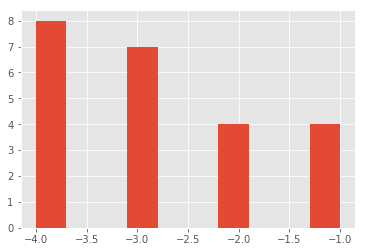

In [35]:
plt.hist(df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)])


Analizirajmo sada i donju skupinu (starosti iz intervala $ \left[ {- 7986} \mathinner{\ldotp \ldotp} {- 7994} \right] $).


In [36]:
df.loc[df.STAROST < -1000]


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
38057,2014-09-30,639748,7479194,2014-08-13,2014-08-13,2014-12-09,50000.00,50000.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,False
80261,2011-09-30,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15422303.88,15669257.06,2,1110,FL0202,A,0.0000,B,-7993,False
86903,2012-03-31,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15749562.80,15700407.25,2,1110,FL0202,A,0.0000,B,-7993,False
148126,2011-12-31,163404,6649818,2011-12-30,NaT,NaT,84000.00,NaN,84000.00,1,1430,TM0109,L,2.2000,A,-7993,False
152783,2014-06-30,639748,7479194,2014-02-13,2014-08-13,NaT,50000.00,50000.00,50000.00,1,1430,TM0109,L,0.7181,A,-7991,False
168432,2012-06-30,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7993,True
216361,2014-12-31,639748,7479194,2014-08-13,2015-02-13,2014-12-09,50000.00,0.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,True
260433,2012-03-31,991796,4786159,2009-12-02,2012-12-31,NaT,6700951.27,978824.17,975769.19,2,1110,FL0202,A,0.0000,B,-7993,False
303304,2012-12-31,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7992,True
316395,2012-09-30,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7992,True


In [37]:
df.loc[df.STAROST < -1000].shape[0]


In [38]:
df.STAROST[df.STAROST < -1000].describe()


count    3344.000000
mean    -7987.241926
std         1.278142
min     -7994.000000
25%     -7988.000000
50%     -7987.000000
75%     -7987.000000
max     -7986.000000
Name: STAROST, dtype: float64

In [39]:
analiziraj_num_stupac(df.STAROST[df.STAROST < -1000])


{'max': -7986, 'min': -7994, 'nulls': 0, 'range': 8, 'uniques': 9}

(array([  17.,   45.,   38.,   28.,    0.,   18.,   14.,  812., 1596.,
         776.]),
 array([-7994. , -7993.2, -7992.4, -7991.6, -7990.8, -7990. , -7989.2,
        -7988.4, -7987.6, -7986.8, -7986. ]),
 <a list of 10 Patch objects>)

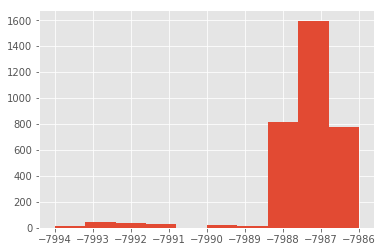

In [40]:
plt.hist(df.STAROST[df.STAROST < -1000])


Neobično je, također, i što postoji starost veća (ne nužno strogo) od $ 900 $ godina<sup>[3](#fnote-3)</sup>. Zapravo, pozitivne starosti su također polarizirane u intervale $ \left[ 1 \mathinner{\ldotp \ldotp} 107 \right] $ i $ \left[ 900 \mathinner{\ldotp \ldotp} 908 \right] $. Naravno da je moguće da je neko poduzeće staro $ 900 $-tinjak godina, ali prvi moderni bankari bili su križari &mdash; to bi značilo da su najstariji suvremeni klijenti *RBA* bankarske usluge mogli tražiti još od prvih bankara na svijetu. Za razliku od negativne starosti, ovaj fenomen nije nemoguć, ali vrlo je malo vjerojatan.

Promotrimo, dakle, te dijelove tablice.


In [41]:
df.loc[df.STAROST >= 500]


,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
255736,2014-06-30,633817,7146342,2014-02-07,2014-08-07,2014-05-13,18894.93,19242.86,0.00,2,1430,TM0109,L,0.2636,A,903,True
448131,2014-03-31,633817,7146342,2014-02-07,2014-02-07,NaT,18894.93,19190.72,19242.86,2,1430,TM0109,L,0.2636,A,903,False
473275,2012-12-31,633817,7146342,2012-08-07,2013-02-07,NaT,18894.93,18718.60,18959.51,2,1430,TM0109,L,2.3877,A,902,False
495918,2012-09-30,633817,7146342,2012-08-07,NaT,NaT,18894.93,NaN,18718.60,2,1430,TM0109,L,2.3877,A,901,False
594746,2013-09-30,633817,7146342,2013-08-07,2013-08-07,NaT,18894.93,18722.62,19125.27,2,1430,TM0109,L,0.3636,A,902,False
643347,2012-06-30,390595,6090636,2011-05-26,2012-02-02,2012-03-02,21068.94,0.00,0.00,1,1430,FL0900,A,9.7000,C,901,False
653454,2011-09-30,390595,6090636,2011-05-26,2012-05-28,NaT,21068.94,19479.30,14170.05,1,1430,FL0900,A,9.7000,C,900,False
918389,2013-03-31,633817,7146342,2013-02-07,2013-02-07,NaT,18894.93,18959.51,19062.79,2,1430,TM0109,L,0.7800,A,902,False
1069017,2012-12-31,390595,6090636,2011-05-26,2012-02-02,2012-03-02,21068.94,0.00,0.00,1,1430,FL0900,A,9.7000,C,902,False
1138169,2011-06-30,390595,6090636,2011-05-26,NaT,NaT,21068.94,NaN,19479.30,1,1430,FL0900,A,9.7000,C,900,False


In [42]:
df.loc[df.STAROST >= 500].shape[0]


In [43]:
df.STAROST[df.STAROST >= 500].describe()


count    467.000000
mean     903.304069
std        2.234543
min      900.000000
25%      901.000000
50%      903.000000
75%      905.000000
max      908.000000
Name: STAROST, dtype: float64

In [44]:
analiziraj_num_stupac(df.STAROST[df.STAROST >= 500])


{'max': 908, 'min': 900, 'nulls': 0, 'range': 8, 'uniques': 9}

(array([55., 76., 62., 47.,  0., 69., 77., 35., 37.,  9.]),
 array([900. , 900.8, 901.6, 902.4, 903.2, 904. , 904.8, 905.6, 906.4,
        907.2, 908. ]),
 <a list of 10 Patch objects>)

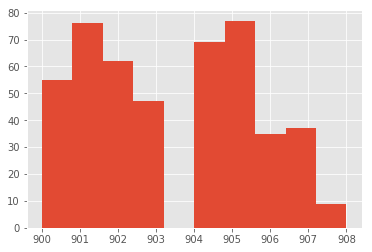

In [45]:
plt.hist(df.STAROST[df.STAROST >= 500])


<sup><a name="fnote-3"></a>3</sup> Za klijente čija je starost negativna ili nevjerojatno velika ne zna se datum osnutka odnosno rođenja. &larr; **POTVRDIO NARUČITELJ ZADATKA**


***TO DO:*** Pogledati i ostala sumnjiva mjesta (gdje je planirani datum zatvaranja ili datum zatvaranja prije datuma otvaranja); revidirati sumnjiva mjesta gdje je planirani datum zatvaranja nedefiniran.


## Vremenski nizovi <a name="vremenski-nizovi"></a>


Pokušat ćemo iz danih podataka konstruirati vremenske nizove za klijente. Da bismo to napravili, grupirajmo prvo podatke s obzirom na klijente i partije.


In [46]:
kp_df = df.groupby(['KLIJENT_ID', 'OZNAKA_PARTIJE'])


Sortirajmo uređene parove $ \left( \text{KLIJENT_ID} , \text{OZNAKA_PARTIJE} \right) $ u niz `kp` tako da za svaki $ \mathtt{i} \in \left( 0 \mathinner{\ldotp \ldotp} \mathtt{len(kp)} - 2 \right) $ tablica `kp_df.get_group(*kp[i])` ima više (ne nužno strogo) redaka od tablice `kp_df.get_group(*kp[i + 1])`.


In [47]:
kp = kp_df.size().sort_values(ascending = False).index


Konačno, definirajmo klase `VremenskiNiz` i `Klijent` čije će instance *reprezentirati* vremenske nizove konkretnih partija klijenta i vremenske nizove svih partija klijenta reprezentativno (instance tih klasa ne će zapravo reprezentirati vremenske nizove, nego će samo sadržavati atribute s ekstrahiranim podatcima iz originalne tablice sortiranim s obzirom na vrijeme).


In [48]:
##  DEFINICIJE NEKIH KLASA ZA EKSTRAKCIJU VREMENSKIH NIZOVA

class VremenskiNiz (object):
    """
    Klasa za reprezentaciju vremenskog niza zbivanja jedne partije.

    """

    @classmethod
    def prviDatum (cls, stupac):
        """
        Dohvati prvi definirani datum u stupcu.

        Ako ne postoji, povratna vrijednost je pandas.NaT.

        """

        i = stupac.first_valid_index()

        if i is None:
            return pd.NaT

        return stupac.loc[i]

    @classmethod
    def zadnjiDatum (cls, stupac):
        """
        Dohvati prvi definirani datum u stupcu.

        Ako ne postoji, povratna vrijednost je pandas.NaT.

        """

        i = stupac.last_valid_index()

        if i is None:
            return pd.NaT

        return stupac.loc[i]

    def __init__ (self, KLIJENT_ID, OZNAKA_PARTIJE):
        """
        Inicijaliziraj vremenski niz partija klijenta.

        Postavljaju se atributi KLIJENT_ID, OZNAKA_PARTIJE i df
        (gdf.get_group(self.KLIJENT_ID, self.OZNAKA_PARTIJE)).

        """

        self.KLIJENT_ID = KLIJENT_ID
        self.OZNAKA_PARTIJE = OZNAKA_PARTIJE
        self.df = kp_df.get_group(
            (self.KLIJENT_ID, self.OZNAKA_PARTIJE)
        ).sort_values(
            by = [
                'DATUM_IZVJESTAVANJA',
                'DATUM_OTVARANJA',
                'PLANIRANI_DATUM_ZATVARANJA',
                'DATUM_ZATVARANJA',
                'PRIJEVREMENI_RASKID'
            ],
            ascending = [True, True, True, True, False]
        )

    def __copy__ (self):
        """
        Dohvati copy.copy(self).

        """

        return VremenskiNiz(
            copy.copy(self.KLIJENT_ID),
            copy.copy(self.OZNAKA_PARTIJE)
        )

    def __deppcopy__ (self, memo = dict()):
        """
        Dohvati copy.deepcopy(self, memo).

        Moguce je da atribut df kopije ne ce biti duboka kopija self.df.

        """

        return VremenskiNiz(
            copy.deepcopy(self.KLIJENT_ID, memo),
            copy.deepcopy(self.OZNAKA_PARTIJE, memo)
        )

    def __repr__ (self):
        """
        Dohvati repr(self).

        """

        return '<VremenskiNiz: ({0:d}, {1:d})>'.format(
            self.KLIJENT_ID, self.OZNAKA_PARTIJE
        )

    def __len__ (self):
        """
        Dohvati len(self).

        Vraca se self.df.shape[0]

        """

        return int(self.df.shape[0])

#   def __iter__ (self):
#       """
#       Iteriraj po vremenskom nizu.
#
#       Vracaju se retci u self.df redom od prvog do zadnjeg.
#
#       """
#
#       for i in range(self.df.shape[0]):
#           yield self.df.iloc[i, :]

    def __getitem__ (self, key):
        """
        Dohvati self[key].

        Vraca se self.df.loc[key].

        """

        return self.df.loc[key]

    def __eq__ (self, other):
        """
        Dohvati self == other.

        Usporeduju se atributi KLIJENT_ID, OZNAKA_PARTIJE i svi elementi tablice
        (metodom pandas.DataFrame.equals).

        """

        return (
            self.KLIJENT_ID == other.KLIJENT_ID and
            self.OZNAKA_PARTIJE == other.OZNAKA_PARTIJE and
            self.df.equals(other.df)
        )

    def __ne__ (self, other):
        """
        Dohvati self != other.

        Vraca se negacija od self == other.

        """

        return not self == other

    def __lt__ (self, other):
        """
        Dohvati self < other.

        Uredaj nije totalni (mozda nije ni parcijalni --- ovisi o nedefiniranim
        vrijednostima (NaN)), a usporeduju se samo elementi u stupcima
        DATUM_IZVJESTAVANJA, DATUM_OTVARANJA, PLANIRANI_DATUM_ZATVARANJA,
        DATUM_ZATVARANJA i PRIJEVREMENI_RASKID.

        """

        self_nbreak = np.flipud(
            np.logical_not(
                np.flipud(self.df.PRIJEVREMENI_RASKID.cumsum()).astype(bool)
            )
        )
        other_nbreak = np.flipud(
            np.logical_not(
                np.flipud(other.df.PRIJEVREMENI_RASKID.cumsum()).astype(bool)
            )
        )

        for i in range(min(self.df.shape[0], other.df.shape[0])):
            self_test = (
                VremenskiNiz.prviDatum(self.df.DATUM_IZVJESTAVANJA.iloc[i:]),
                VremenskiNiz.prviDatum(self.df.DATUM_OTVARANJA.iloc[i:]),
                VremenskiNiz.zadnjiDatum(
                    self.df.PLANIRANI_DATUM_ZATVARANJA.iloc[i:]
                ),
                VremenskiNiz.zadnjiDatum(self.df.DATUM_ZATVARANJA.iloc[i:]),
                self_nbreak[i]
            )
            other_test = (
                VremenskiNiz.prviDatum(other.df.DATUM_IZVJESTAVANJA.iloc[i:]),
                VremenskiNiz.prviDatum(other.df.DATUM_OTVARANJA.iloc[i:]),
                VremenskiNiz.zadnjiDatum(
                    other.df.PLANIRANI_DATUM_ZATVARANJA.iloc[i:]
                ),
                VremenskiNiz.zadnjiDatum(other.df.DATUM_ZATVARANJA.iloc[i:]),
                other_nbreak[i]
            )

            if self_test < other_test:
                return True
            if self_test != other_test:
                return False

        return self.df.shape[0] < other.df.shape[0]

    def __gt__ (self, other):
        """
        Dohvati self < other.

        Vraca se other < self.

        """

        return other < self

    def __le__ (self, other):
        """
        Dohvati self <= other.

        Uredaj nije totalni (mozda nije ni parcijalni --- ovisi o nedefiniranim
        vrijednostima (NaN)), a usporeduju se samo elementi u stupcima
        DATUM_IZVJESTAVANJA, DATUM_OTVARANJA, PLANIRANI_DATUM_ZATVARANJA,
        DATUM_ZATVARANJA i PRIJEVREMENI_RASKID.

        Moguce je da ne vrijedi (not (self > other)) == (self <= other), ponovo
        zbog nedefiniranih vrijednosti (NaN).

        """

        self_nbreak = np.flipud(
            np.logical_not(
                np.flipud(self.df.PRIJEVREMENI_RASKID.cumsum()).astype(bool)
            )
        )
        other_nbreak = np.flipud(
            np.logical_not(
                np.flipud(other.df.PRIJEVREMENI_RASKID.cumsum()).astype(bool)
            )
        )

        for i in range(min(self.df.shape[0], other.df.shape[0])):
            self_test = (
                VremenskiNiz.prviDatum(self.df.DATUM_IZVJESTAVANJA.iloc[i:]),
                VremenskiNiz.prviDatum(self.df.DATUM_OTVARANJA.iloc[i:]),
                VremenskiNiz.zadnjiDatum(
                    self.df.PLANIRANI_DATUM_ZATVARANJA.iloc[i:]
                ),
                VremenskiNiz.zadnjiDatum(self.df.DATUM_ZATVARANJA.iloc[i:]),
                self_nbreak[i]
            )
            other_test = (
                VremenskiNiz.prviDatum(other.df.DATUM_IZVJESTAVANJA.iloc[i:]),
                VremenskiNiz.prviDatum(other.df.DATUM_OTVARANJA.iloc[i:]),
                VremenskiNiz.zadnjiDatum(
                    other.df.PLANIRANI_DATUM_ZATVARANJA.iloc[i:]
                ),
                VremenskiNiz.zadnjiDatum(other.df.DATUM_ZATVARANJA.iloc[i:]),
                other_nbreak[i]
            )

            if self_test <= other_test:
                return True
            if self_test != other_test:
                return False

        return self.df.shape[0] <= other.df.shape[0]

    def __ge__ (self, other):
        """
        Dohvati self >= other.

        Vraca se other <= self.

        """

        return other <= self

class Klijent (object):
    def __init__ (self, KLIJENT_ID):
        """
        Inicijaliziraj klijenta.

        Postavljaju se atributi KLIJENT_ID i ser (sortirani numpy.ndarray svih
        vremenskih nizova partija danog klijenta).

        """

        self.KLIJENT_ID = KLIJENT_ID
        self.ser = np.sort(
            [
                VremenskiNiz(self.KLIJENT_ID, kp_x[1]) for kp_x in kp
                    if kp_x[0] == self.KLIJENT_ID
            ]
        )

    def __copy__ (self):
        """
        Dohvati copy.copy(self).

        """

        return Klijent(copy.copy(self.KLIJENT_ID))

    def __deepcopy__ (self, memo = dict()):
        """
        Dohvati copy.deepcopy(self, memo).

        """

        return Klijent(copy.deepcopy(self.KLIJENT_ID))

    def __repr__ (self):
        """
        Dohvati repr(self).

        """

        return '<Klijent: {0:d}>'.format(self.KLIJENT_ID)

    def __len__ (self):
        """
        Dohvati len(self).

        Vraca se self.ser.size.

        """

        return int(self.ser.size)

    def __iter__ (self):
        """
        Iteriraj po vremenskim nizovima klijenta.

        Vracaju se elementi self.ser redom od prvog do zadnjeg.

        """

        for i in range(self.ser.size):
            yield self.ser[i]

    def __getitem__ (self, key):
        """
        Dohvati self.ser[key].

        """

        return self.ser[key]

    def __eq__ (self, other):
        """
        Dohvati self == other.

        Usporeduju se atribut KLINET_ID i jednakost nizova self.ser i other.ser
        (funkcijom numpy.array_equal).

        """

        return (
            self.KLIJENT_ID == other.KLIJENT_ID and
            np.array_equal(self.ser, other.ser)
        )

    def __ne__ (self, other):
        """
        Dohvati self != other.

        Dohvaca se negacija self == other.

        """

        return not self == other

    def __lt__ (self, other):
        """
        Dohvati self < other.

        Leksikografski se usporeduju self.ser i other.ser.

        Buduci da uredaj na klasi VremenskiNiz nije nuzno totalan, ni ovaj
        uredaj nije nuzno totalan.

        """

        return self.ser.tolist() < other.ser.tolist()

    def __gt__ (self, other):
        """
        Dohvati self > other.

        Vraca se other < self.

        """

        return other < self

    def __le__ (self, other):
        """
        Dohvati self <= other.

        Leksikografski se usporeduju self.ser i other.ser.

        Buduci da uredaj na klasi VremenskiNiz nije nuzno totalan, ni ovaj
        uredaj nije nuzno totalan.

        Moguce je da ne vrijedi (not (self > other)) == (self <= other), ponovo
        zbog netotalnosti uredaja na klasi VremenskiNiz.

        """

        return self.ser.tolist() <= other.ser.tolist()

    def __ge__ (self, other):
        """
        Dohvati self >= other.

        Vraca se other <= self.

        """

        return other <= self
